In [93]:
import jax 
import optax

import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

from jax.random import PRNGKey, split

from weight_uncertainty.meanfield_vi import meanfield_vi

Generate linear data

In [168]:
key = PRNGKey(1)
n = 25

key, subkey = split(key)
f = lambda x: 2 * x + jax.random.normal(subkey, shape=(n, 1)) * 0.1

key, subkey = split(key)
x = jax.random.uniform(subkey, shape=(n, 1),)
y = f(x)

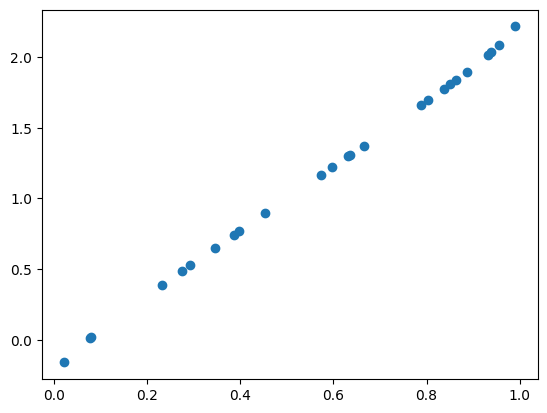

In [169]:
plt.scatter(x, y)

In [188]:
def loglikelihood(params, batch):
    x,y = batch
    slope, intercept = params["slope"], params["intercept"]
    out = slope @ x + intercept
    return - jnp.mean((out - y) ** 2)
loglikelihood = jax.vmap(loglikelihood, in_axes=[None, 0])

def logprior(params):
    out = jax.tree_map(stats.norm.logpdf, params)
    out = jax.tree_map(jnp.sum, out)
    out = jax.tree_util.tree_reduce(jnp.add, out)
    return out

def logjoint(params, batch):
    return 25 * loglikelihood(params, batch) + logprior(params)
logjoint = jax.vmap(logjoint, in_axes=[0, None])

def data_stream(seed, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    rng = np.random.RandomState(seed)
    num_batches = int(jnp.ceil(data_size / batch_size))
    while True:
        perm = rng.permutation(data_size)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield data[batch_idx]

def compute_predictions(params, x):
    slope, intercept = params["slope"], params["intercept"]
    out = slope @ x + intercept
    return out
compute_predictions = jax.vmap(compute_predictions, in_axes=[None, 0])

In [197]:
optimizer = optax.adam(5e-4)
mfvi = meanfield_vi(loglikelihood, optimizer, 30)

pos = {"slope": jnp.array([0.0]), "intercept": jnp.array([0.0])}
mfvi_state = mfvi.init(pos)


In [198]:
for i in range(50_000):
    batch = (x, y)
    mfvi_state, mfvi_info, key = mfvi.step(key, mfvi_state, batch)

    if i % 25 == 0:
        print(
            f"Elbo at step {i} | {mfvi_info.elbo} | Log variational: {mfvi_info.log_variational} | Log joint: {mfvi_info.log_joint}"
        )

Elbo at step 0 | -139.96925354003906 | Log variational: -153.4612274169922 | Log joint: -13.491978645324707
Elbo at step 25 | -131.0565948486328 | Log variational: -143.99253845214844 | Log joint: -12.935948371887207
Elbo at step 50 | -142.5844268798828 | Log variational: -159.86331176757812 | Log joint: -17.27889060974121
Elbo at step 75 | -136.11448669433594 | Log variational: -148.4598388671875 | Log joint: -12.345351219177246
Elbo at step 100 | -129.794189453125 | Log variational: -138.7078399658203 | Log joint: -8.913647651672363
Elbo at step 125 | -137.09146118164062 | Log variational: -151.0867919921875 | Log joint: -13.995326042175293
Elbo at step 150 | -142.20310974121094 | Log variational: -155.49179077148438 | Log joint: -13.288681030273438
Elbo at step 175 | -133.95262145996094 | Log variational: -145.0153045654297 | Log joint: -11.062676429748535
Elbo at step 200 | -132.99378967285156 | Log variational: -144.5705108642578 | Log joint: -11.576714515686035
Elbo at step 225 |

In [199]:
params, key = mfvi.sample(key, mfvi_state, 25)

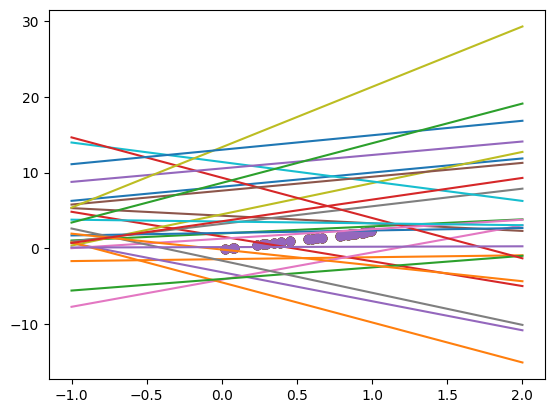

In [200]:
x_ = jnp.linspace(-1, 2).reshape(-1, 1)
lines = []
slopes, intercepts = params.values()
for slope, intercept in zip(slopes, intercepts):
    pred = compute_predictions({"slope": slope, "intercept": intercept}, x_)
    lines.append(pred)

for line in lines:
    
    plt.plot(x_, line.squeeze())
    plt.scatter(x, y)

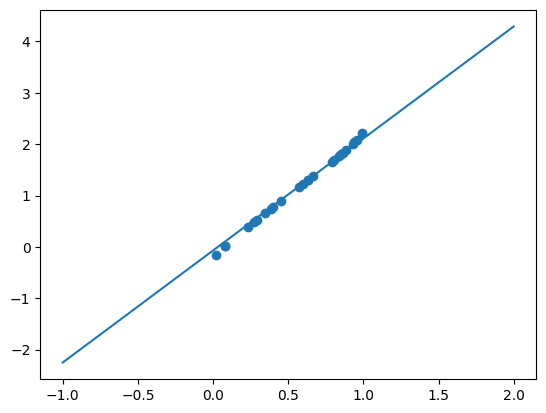

In [201]:
mean_pred = compute_predictions(mfvi_state.mu, x_)
plt.plot(x_, mean_pred)
plt.scatter(x, y)